In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
PATH_TO_DATA = "/content/gdrive/MyDrive/data" 
!ls {PATH_TO_DATA}

with_mask  without_mask


In [33]:
import numpy as np 
import pandas as pd 
import os
import cv2

In [34]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [35]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

In [36]:
train_dataset = image_dataset_from_directory(PATH_TO_DATA,
                                              validation_split=0.3,
                                              subset= "training",
                                              seed=42,
                                              image_size= IMG_SIZE,
                                              batch_size=BATCH_SIZE)


Found 7553 files belonging to 2 classes.
Using 5288 files for training.


In [37]:
validation_dataset = image_dataset_from_directory(PATH_TO_DATA,
                                                  validation_split = 0.3,
                                                  shuffle=True,
                                                  subset= "validation",
                                                  seed=42,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE
                                                  )

Found 7553 files belonging to 2 classes.
Using 2265 files for validation.


In [38]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [39]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 57
Number of test batches: 14


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [41]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [42]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [43]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [44]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [45]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [46]:
base_model.trainable = False

In [47]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [48]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [49]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [50]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [51]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [53]:
len(model.trainable_variables)

2

In [54]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

57/57 [==============================] - 360s 4s/step - loss: 0.8470 - accuracy: 0.4382


In [55]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.44


In [56]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
166/166 [==============================] - 795s 5s/step - loss: 0.6063 - accuracy: 0.6630 - val_loss: 0.4110 - val_accuracy: 0.7942
Epoch 2/5
166/166 [==============================] - 161s 968ms/step - loss: 0.3735 - accuracy: 0.8306 - val_loss: 0.2522 - val_accuracy: 0.9070
Epoch 3/5
166/166 [==============================] - 165s 990ms/step - loss: 0.2877 - accuracy: 0.8826 - val_loss: 0.1833 - val_accuracy: 0.9395
Epoch 4/5
166/166 [==============================] - 164s 983ms/step - loss: 0.2390 - accuracy: 0.9041 - val_loss: 0.1468 - val_accuracy: 0.9543
Epoch 5/5
166/166 [==============================] - 162s 972ms/step - loss: 0.2040 - accuracy: 0.9244 - val_loss: 0.1234 - val_accuracy: 0.9620


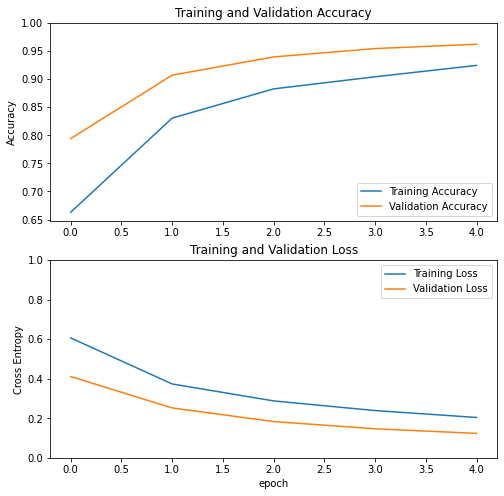

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()